In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sesd
import statsmodels.api as sm
import os
import os.path as path

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (7, 5), 'figure.dpi': 120})

# Exploratory data analysis

In [3]:
df = pd.read_csv('../data/raw/stoloto_data.csv',
                       sep=',',
                       parse_dates=['date'], index_col=0)

### A glance at the dataset

In [4]:
df.head(10)

,ops_num,game_code,circulation,ufps_num,postamt_num,sales,date
0,117463,7105,216,2,165,57,2017-01-15
2,117218,7105,217,2,165,17,2017-01-22
4,109518,7105,218,2,484,16,2017-01-29
8,119311,7105,209,2,306,22,2016-11-27
13,105043,7105,212,2,224,25,2016-12-18
14,119192,7105,213,2,306,22,2016-12-25
17,119619,7105,261,2,306,68,2017-11-26
20,119619,7105,262,2,306,51,2017-12-03
31,111622,7105,294,2,224,16,2018-07-15
50,111398,7105,244,2,224,10,2017-07-30


In [5]:
df.describe()

,ops_num,game_code,circulation,ufps_num,postamt_num,sales
count,30021.000000,30021.000000,30021.000000,30021.0,30021.000000,30021.000000
mean,119014.466473,7110.333133,464.024050,2.0,328.856101,44.893808
std,7361.429245,17.107149,475.309325,0.0,203.664387,143.597791
min,103132.000000,7101.000000,1.000000,2.0,96.000000,3.000000
25%,115088.000000,7103.000000,121.000000,2.0,165.000000,16.000000
50%,119602.000000,7105.000000,239.000000,2.0,306.000000,24.000000
75%,125430.000000,7115.000000,1173.000000,2.0,484.000000,41.000000
max,129338.000000,7175.000000,1269.000000,2.0,664.000000,5771.000000


In [6]:
# So we have 30021 values for all columns, no NaN values.
# I don't see much physical meaning in statistics for categolical features such game_code, postamt_num, ufps_num
# Hmm, std for 'ufps_num' is 0. Let's check is it a constant
df['ufps_num'].value_counts() 

2    30021
Name: ufps_num, dtype: int64

In [7]:
# Yes, it is. It's useless, let's delete it
del df['ufps_num']

In [8]:
game_codes_counts = df['game_code'].value_counts()
# game_code have only 5 possible values. Probably we should change this feature into 5 dummy variables in the regression
game_codes = game_codes_counts.index
print(game_codes)

Int64Index([7103, 7105, 7115, 7101, 7175], dtype='int64')


In [9]:
df['postamt_num'].value_counts()
# Again, postamt_num consist of 6 groups about the same size and can be replaced with 6 dummy variables.

664    5909
96     5759
306    5234
224    4663
484    4247
165    4209
Name: postamt_num, dtype: int64

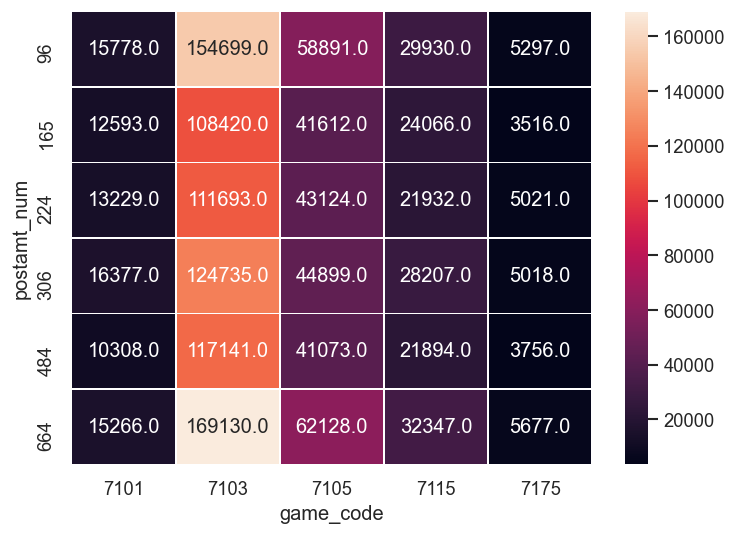

In [10]:
# Let's take a look at spreading sales by combination of postamt_num and game_code
ops_num_game_code_sales = df.pivot_table(
                        index='postamt_num', 
                        columns='game_code', 
                        values='sales', 
                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(ops_num_game_code_sales, annot=True, fmt=".1f", linewidths=.5)

In [11]:
df['circulation'].nunique()

391

In [12]:
df['ops_num'].nunique()

93

So in theory we have 5 game_codes * 93 ops_nums = 465 time series to make s forecast

#### Features correlation check

In [13]:
df.corr()

,ops_num,game_code,circulation,postamt_num,sales
ops_num,1.000000,-0.007007,0.004413,0.041359,0.004647
game_code,-0.007007,1.000000,-0.351192,0.003224,-0.074986
circulation,0.004413,-0.351192,1.000000,0.009910,0.219951
postamt_num,0.041359,0.003224,0.009910,1.000000,0.008260
sales,0.004647,-0.074986,0.219951,0.008260,1.000000


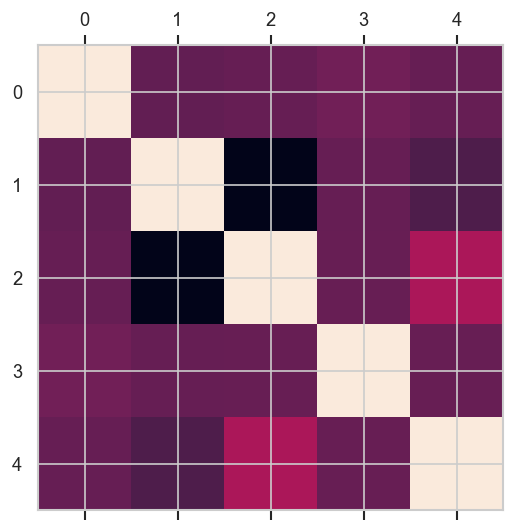

In [14]:
plt.matshow(df.corr())
plt.show()
#We have weak correlation between circulation and game_code (-0.35) but we still can work with it.

#### Target variable survey

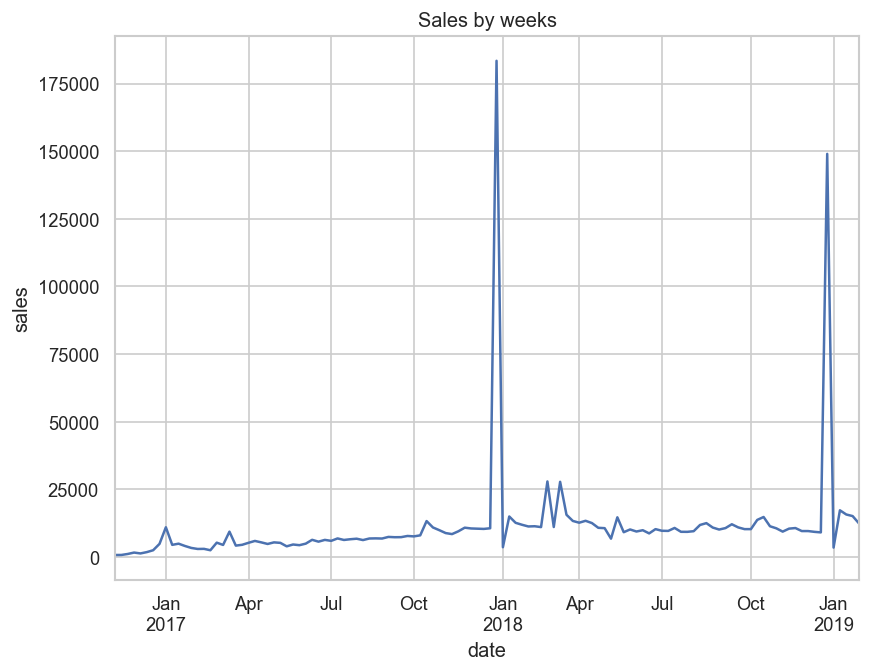

In [15]:
common_sales = df.sort_values(by=['date']).groupby('date').sum()['sales']
common_sales.plot(figsize=(8,6))
plt.ylabel('sales')
plt.title('Sales by weeks')
plt.show()

We can see two big outlaers in the end of two last years

#### Prepare Time Series

In [16]:
df_grouped = df.sort_values(by=['date']).groupby(['game_code', 'ops_num', 'date'])['sales'].sum()
multiindex_count = df_grouped.index.to_frame()
temp_df = pd.DataFrame(multiindex_count[['game_code', 'ops_num', 'date']].values, columns=['game_code', 'ops_num', 'date'])
temp_df['sales'] = df_grouped.values
multi_ts = df_grouped.unstack([0, 1])
multi_ts.head(10)

game_code    7101                                                          \
ops_num    105005 105043 105066 105264 105523 105554 105568 107589 109263   
date                                                                        
2016-11-06    NaN    NaN    NaN    NaN    NaN    NaN   15.0    NaN    NaN   
2016-11-13    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-11-20    NaN   23.0    NaN    NaN    NaN    NaN   18.0    NaN    NaN   
2016-11-27    NaN    NaN    NaN   17.0   21.0    NaN   21.0    NaN    NaN   
2016-12-04    NaN    NaN    NaN    NaN    NaN    NaN   20.0    NaN    NaN   
2016-12-11   19.0    NaN    NaN    NaN    NaN    NaN   22.0    NaN    NaN   
2016-12-18   20.0   23.0    NaN   16.0    NaN    NaN   11.0    NaN    NaN   
2016-12-25   22.0    NaN    NaN   16.0   20.0    NaN   24.0    NaN    NaN   
2017-01-01   23.0   22.0   25.0   27.0   20.0   30.0   64.0   18.0    NaN   
2017-01-08    NaN    NaN    NaN   22.0   14.0   14.0    NaN    NaN    NaN   

game_code          ...   7175                                            \
ops_num    109382  ... 127427 127434 127495 127576 129110 129164 129272   
date               ...                                                    
2016-11-06    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-11-13    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-11-20    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-11-27    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-12-04    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-12-11    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-12-18    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-12-25   16.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-01-01   84.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-01-08    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

game_code                        
ops_num    129281 129323 129338  
date                             
2016-11-06    NaN    NaN    NaN  
2016-11-13    NaN    NaN    NaN  
2016-11-20    NaN    NaN    NaN  
2016-11-27    NaN    NaN    NaN  
2016-12-04    NaN    NaN    NaN  
2016-12-11    NaN    NaN    NaN  
2016-12-18    NaN    NaN    NaN  
2016-12-25    NaN    NaN    NaN  
2017-01-01    NaN    NaN    NaN  
2017-01-08    NaN    NaN    NaN  

[10 rows x 436 columns]

In [17]:
multi_ts.isna().sum()

game_code  ops_num
7101       105005      21
           105043      52
           105066      95
           105264      64
           105523      25
                     ... 
7175       129164      87
           129272      91
           129281     116
           129323      95
           129338     108
Length: 436, dtype: int64

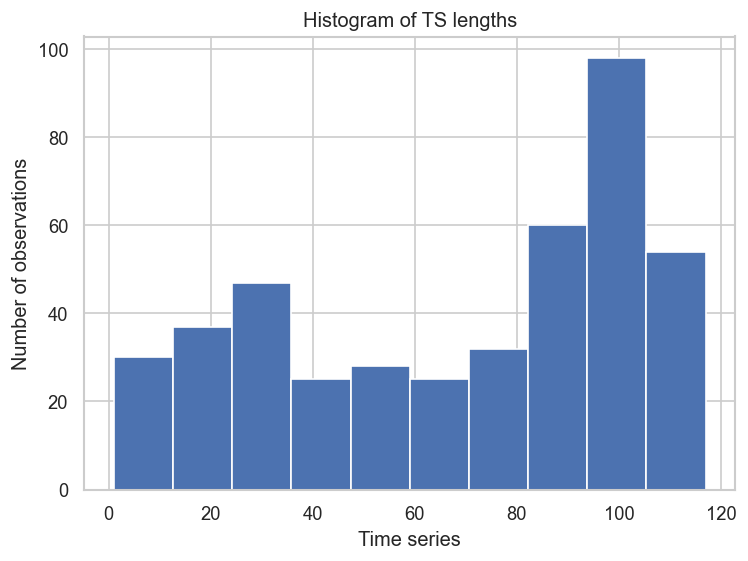

<Figure size 480x300 with 0 Axes>

In [18]:
ts_lengths = pd.DataFrame(len(multi_ts.index)- multi_ts.isna().sum(), columns=['ts_length']).sort_values(by=['ts_length'])

plt.hist(ts_lengths['ts_length'])
plt.xlabel('Time series')
plt.ylabel('Number of observations')
plt.title('Histogram of TS lengths')
plt.figure(figsize=(4,2.5))
plt.show()

In [19]:
# We have 436 time series most of which consist of 22-50 values
# We need to deside the minimum length of time series to predict. Let's assume it to 30
max_number_of_nas = len(multi_ts.index) - 30
ts_min30length = multi_ts.loc[:, (multi_ts.isna().sum(axis=0) <= max_number_of_nas)]
ts_df = pd.DataFrame() 
for i, col in enumerate(ts_min30length.columns):
    ts_df.insert(i, str(col[0])+'_'+str(col[1]), ts_min30length.iloc[:, i])
ts_df.shape

(118, 350)

In [20]:
ts_df.head()

,7101_105005,7101_105043,7101_105264,7101_105523,7101_105554,7101_105568,7101_107589,7101_109263,7101_109382,7101_109383,...,7175_119311,7175_119619,7175_121374,7175_124460,7175_125222,7175_125239,7175_127204,7175_127276,7175_129110,7175_129164
date,,,,,,,,,,,,,,,,,,,,,
2016-11-06,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-20,NaN,23.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-27,NaN,NaN,17.0,21.0,NaN,21.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-04,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We left 350 time series for individual forecasting with minimum 30 values

Let's take a look at 10 random time series

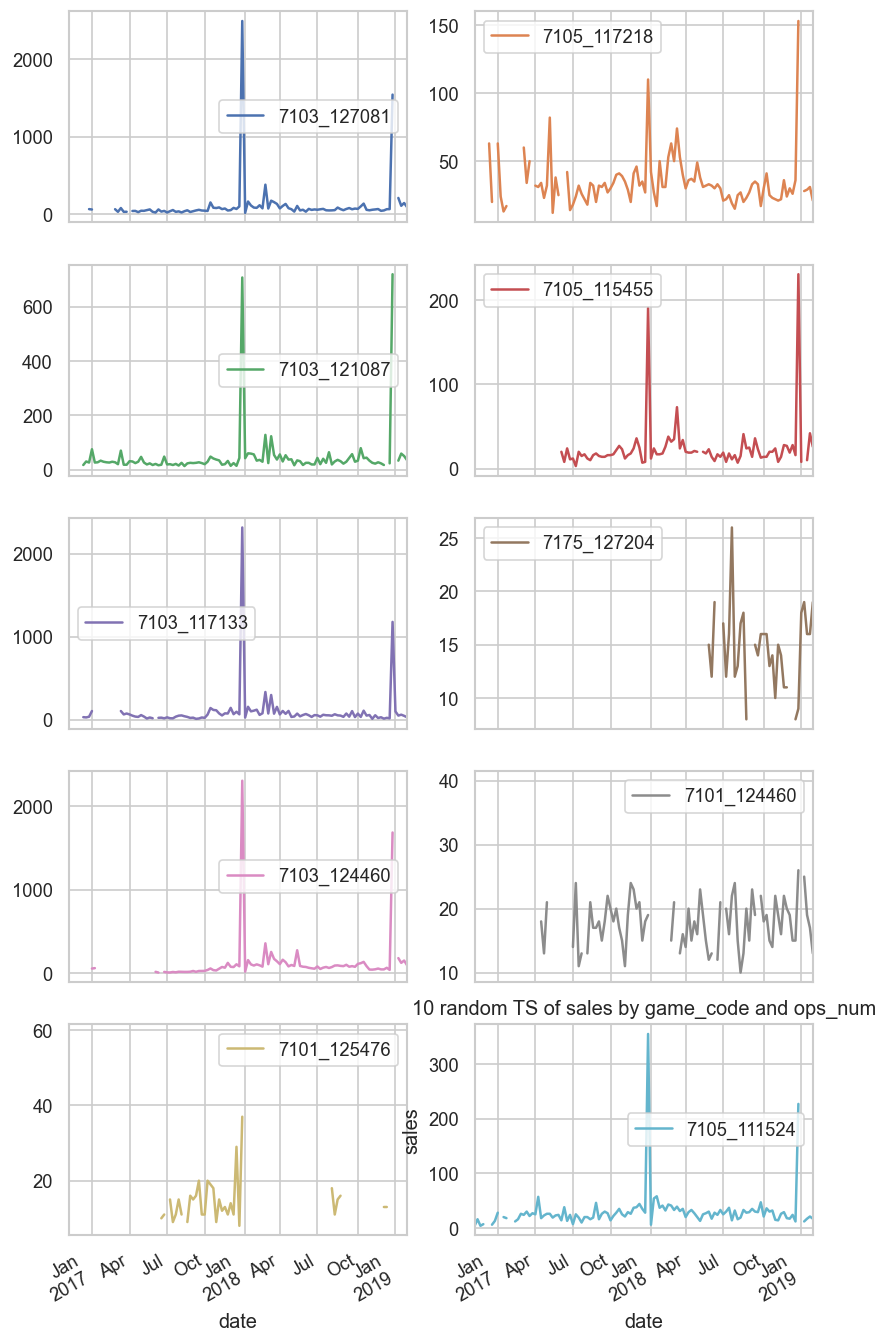

In [21]:
ts_rand = ts_df.sample(10, axis=1)
ts_rand.plot(subplots=True, layout=(5,2), figsize=(8,15))
plt.ylabel('sales')
plt.title('10 random TS of sales by game_code and ops_num')
plt.show()

## Fill missing values

There are lot of NaN values in our time series. We have several approaches of imputation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108c8ae80>,
      dtype=object)

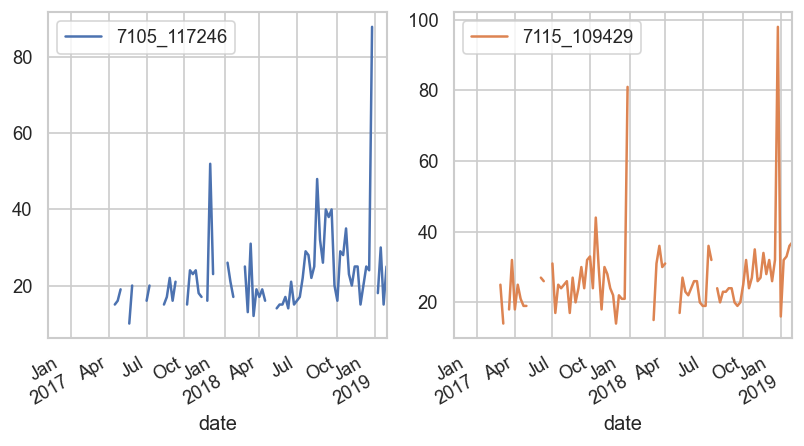

In [22]:
random2ts = ts_df.sample(2, axis=1, random_state=1)
random2ts.plot(subplots=True, layout=(1,2), figsize=(8,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fd976d0>,
      dtype=object)

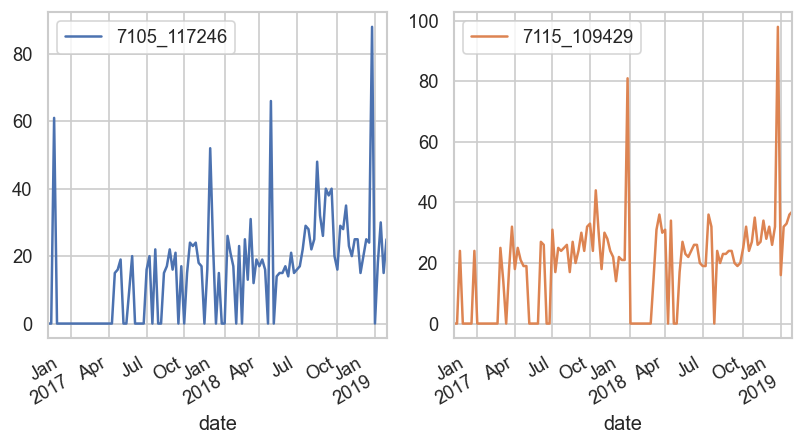

In [23]:
# Fill in with 0.
# Since there are sales by certain game type in every post office for each week so we can assume that no value means 0 sales.
# But if it is not true and data is't complete probably we shouid choose more complicatetd approach such as Backward Fill, Linear Interpolation, Quadratic interpolation, Mean of nearest neighbors
df_zeros = ts_df.fillna(0)
df_zeros[random2ts.columns].plot(subplots=True, layout=(1,2), figsize=(8,4))

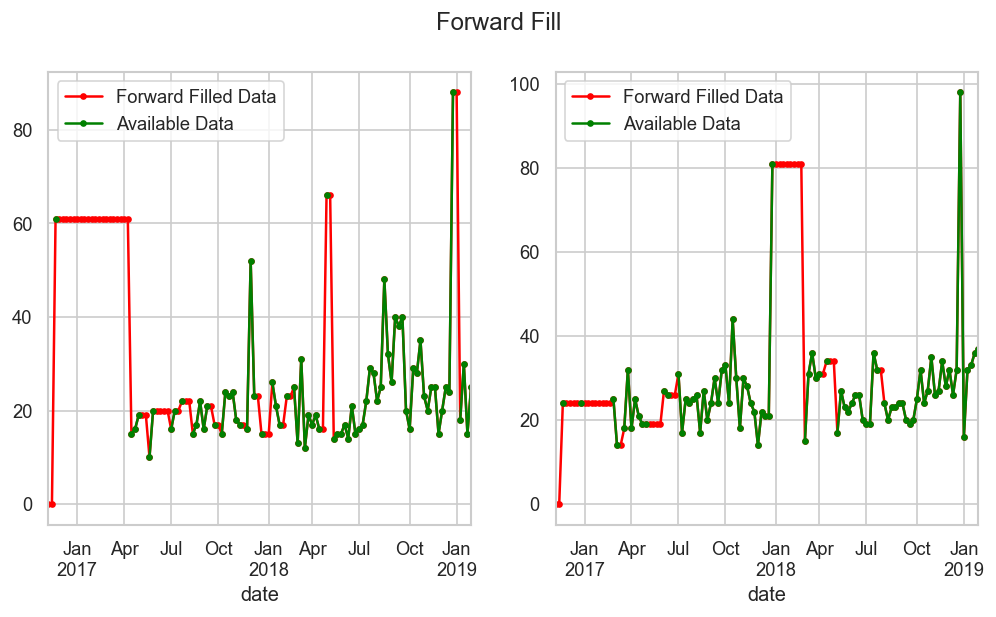

In [24]:
## 2. Forward Fill
df_ffill = ts_df.ffill().fillna(0)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
df_ffill[random2ts.columns[0]].plot(subplots=True, title='Forward Fill', ax=axes[0], label='Forward Fill', color='red', style=".-")
ts_df[random2ts.columns[0]].plot(subplots=True, title='Forward Fill', ax=axes[0], label='Forward Fill', color='green', style=".-")
axes[0].legend(["Forward Filled Data", "Available Data"])
df_ffill[random2ts.columns[1]].plot(subplots=True, title='Forward Fill', ax=axes[1], label='Forward Fill', color='red', style=".-")
ts_df[random2ts.columns[1]].plot(subplots=True, title='Forward Fill', ax=axes[1], label='Forward Fill', color='green', style=".-")
axes[1].legend(["Forward Filled Data", "Available Data"])

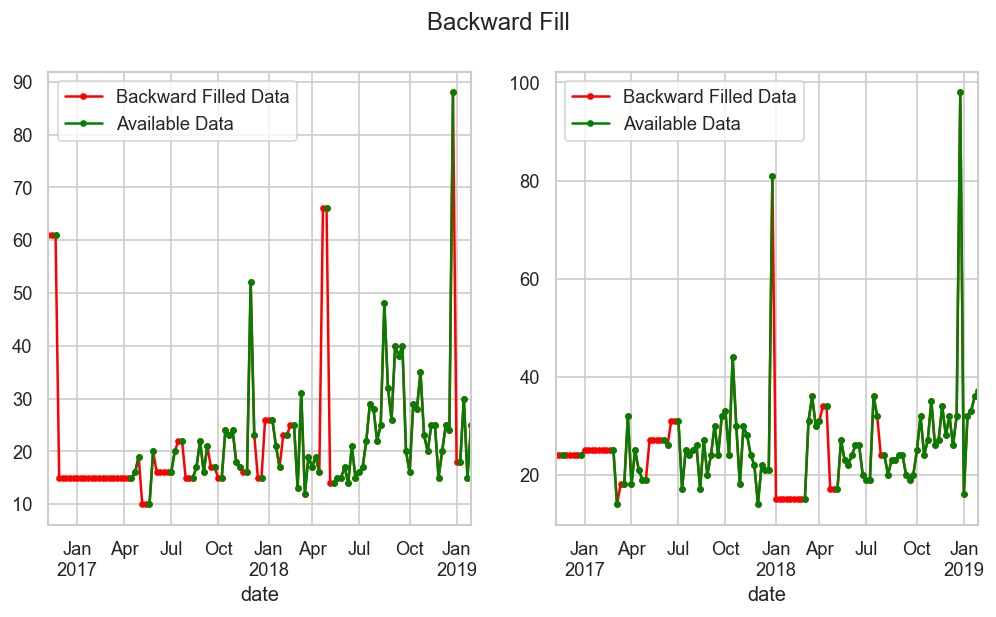

In [25]:
## 3. Backward Fill 
df_bfill = ts_df.bfill()
fig, axes = plt.subplots(1, 2, figsize=(10,5))
df_bfill[random2ts.columns[0]].plot(subplots=True, title='Backward Fill ', ax=axes[0], label='Backward Fill', color='red', style=".-")
ts_df[random2ts.columns[0]].plot(subplots=True, title='Backward Fill', ax=axes[0], label='Backward Fill', color='green', style=".-")
axes[0].legend(["Backward Filled Data", "Available Data"])
df_bfill[random2ts.columns[1]].plot(subplots=True, title='Backward Fill', ax=axes[1], label='Backward Fill', color='red', style=".-")
ts_df[random2ts.columns[1]].plot(subplots=True, title='Backward Fill', ax=axes[1], label='Backward Fill', color='green', style=".-")
axes[1].legend(["Backward Filled Data", "Available Data"])

In [26]:
# Output preprocessed data
__file__ = os.getcwd()
project_path = path.normpath(path.abspath(path.join(__file__,'../')))
df_bfill.to_csv(path.normpath(project_path +
                                '/data/preprocessed/bfilled_ts.csv'), index=True)

In [27]:
## 4. Linear Interpolation
# df_linear = pd.DataFrame()
# ts_df['rownum'] = np.arange(ts_df.shape[0])
# for i, col in enumerate(ts_df.columns[:-1]):
#     df_nona = ts_df.dropna(subset = [col])
#     f = interp1d(df_nona['rownum'], df_nona[col])
#     df_linear[col] = f(ts_df[ts_df.index >= ts_df[col].notna().idxmax()]['rownum'])
# ts_df.drop(['rownum'], axis=1)

# fig, axes = plt.subplots(1, 2, figsize=(10,5))
# df_linear[random2ts.columns[0]].plot(subplots=True, title='Linear Interpolation', ax=axes[0], label='Linear Interpolation', color='red', style=".-")
# ts_df[random2ts.columns[0]].plot(subplots=True, title='Linear Interpolation', ax=axes[0], label='Linear Interpolation', color='green', style=".-")
# axes[0].legend(["Linear Interpolated Data", "Available Data"])
# df_linear[random2ts.columns[1]].plot(subplots=True, title='Linear Interpolation', ax=axes[1], label='Linear Interpolation', color='red', style=".-")
# ts_df[random2ts.columns[1]].plot(subplots=True, title='Linear Interpolation', ax=axes[1], label='Linear Interpolation', color='green', style=".-")
# axes[1].legend(["Linear Interpolated Data", "Available Data"])

<ipython-input-28-bd5c62baf084>:10: RuntimeWarning: Mean of empty slice
  out[i] = np.nanmean(ts_near)


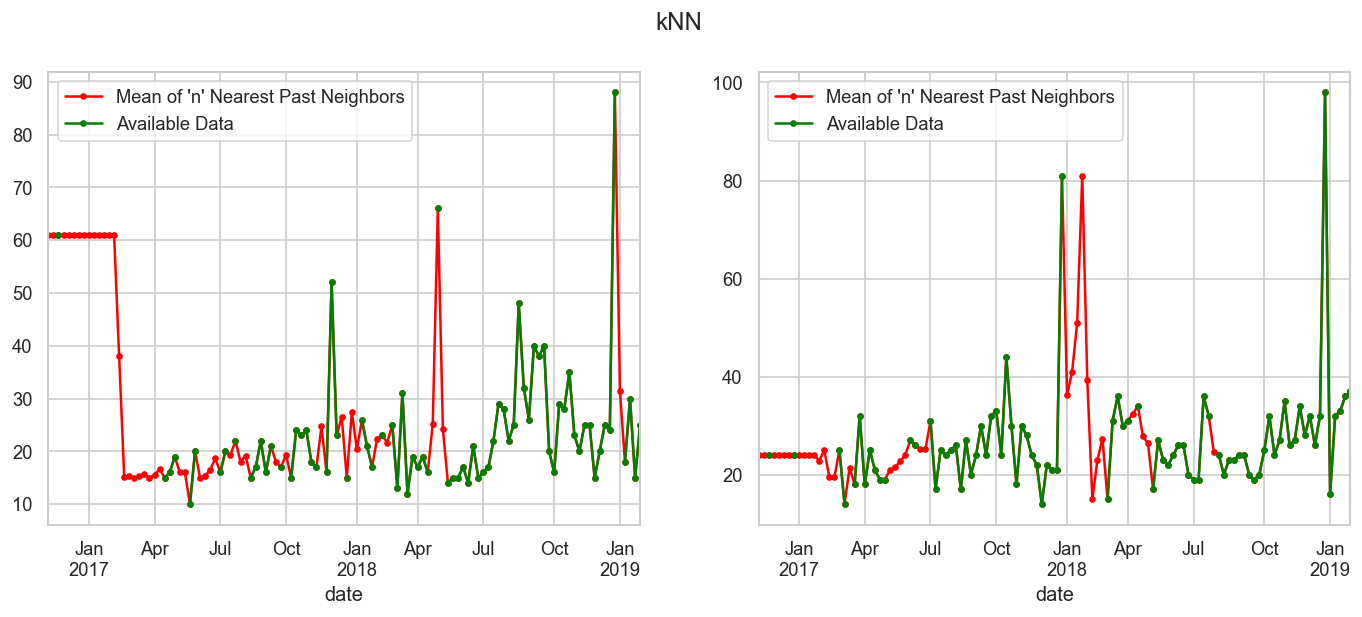

In [28]:
## 6. Mean of 'n' Nearest Past Neighbors
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df_knn = ts_df.copy()
for col in df_knn.columns:
    while df_knn[col].isnull().sum() > 0:
        df_knn[col] = knn_mean(df_knn[col].values, 8)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
df_knn[random2ts.columns[0]].plot(subplots=True, title='kNN', ax=axes[0], label='kNN', color='red', style=".-")
ts_df[random2ts.columns[0]].plot(subplots=True, title='kNN', ax=axes[0], label='kNN', color='green', style=".-")
axes[0].legend(["Mean of 'n' Nearest Past Neighbors", "Available Data"])
df_knn[random2ts.columns[1]].plot(subplots=True, title='kNN', ax=axes[1], label='kNN', color='red', style=".-")
ts_df[random2ts.columns[1]].plot(subplots=True, title='kNN', ax=axes[1], label='kNN', color='green', style=".-")
axes[1].legend(["Mean of 'n' Nearest Past Neighbors", "Available Data"])

In [29]:
# Output preprocessed data
__file__ = os.getcwd()
project_path = path.normpath(path.abspath(path.join(__file__,'../')))
df_knn.to_csv(path.normpath(project_path +
                                '/data/preprocessed/knn_imputated_ts.csv'), index=True)

We can see that TS with different game_code may differ from each other. 

#### Game code TS

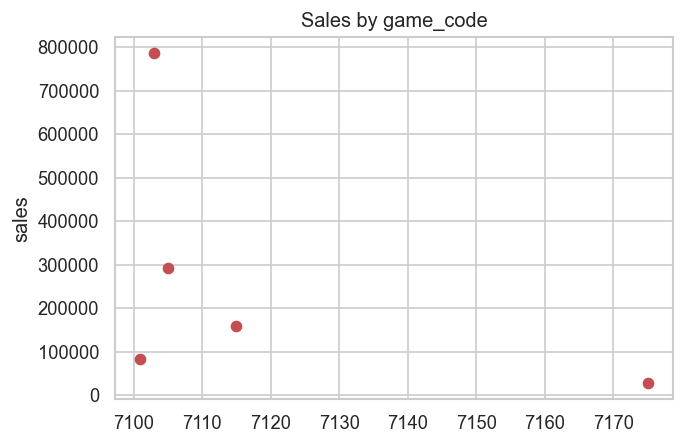

In [30]:
game_code_df = temp_df.groupby('game_code').sum()
fig = plt.figure(figsize=(6, 4))
plt.ylabel('sales')
plt.title('Sales by game_code')
plt.plot(game_code_df, 'ro')

Sales value sugnificatly differ from game type

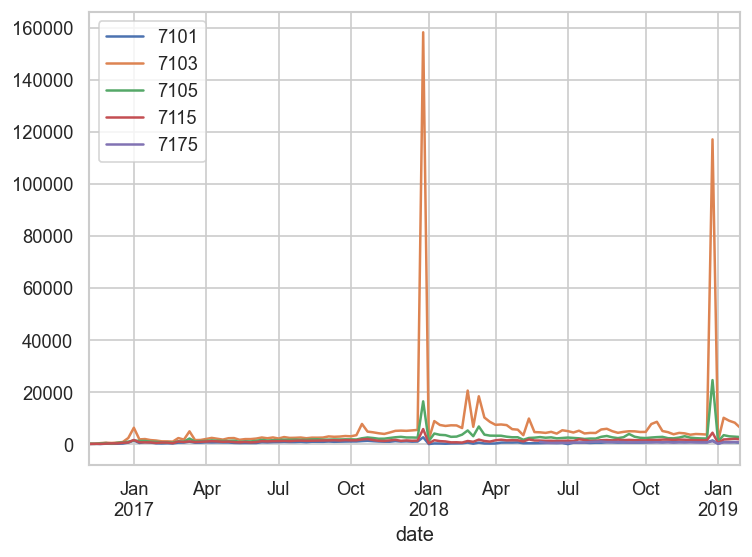

In [31]:
game_code_ts = temp_df.groupby(['game_code', 'date']).sum()
ts_by_game_code = game_code_ts.unstack([0])
#ts_by_game_code.droplevel(0, axis=1)
ts_by_game_code.columns = [col[1] for col in ts_by_game_code.columns]
ts_by_game_code.plot()

TS have too strong outliers. Let's remove it to see other parts of plot.

In [32]:
for i in range(5):
    print(ts_by_game_code.iloc[:, [i]].idxmax())

7101   2017-12-31
dtype: datetime64[ns]
7103   2017-12-31
dtype: datetime64[ns]
7105   2018-12-30
dtype: datetime64[ns]
7115   2017-12-31
dtype: datetime64[ns]
7175   2018-12-30
dtype: datetime64[ns]


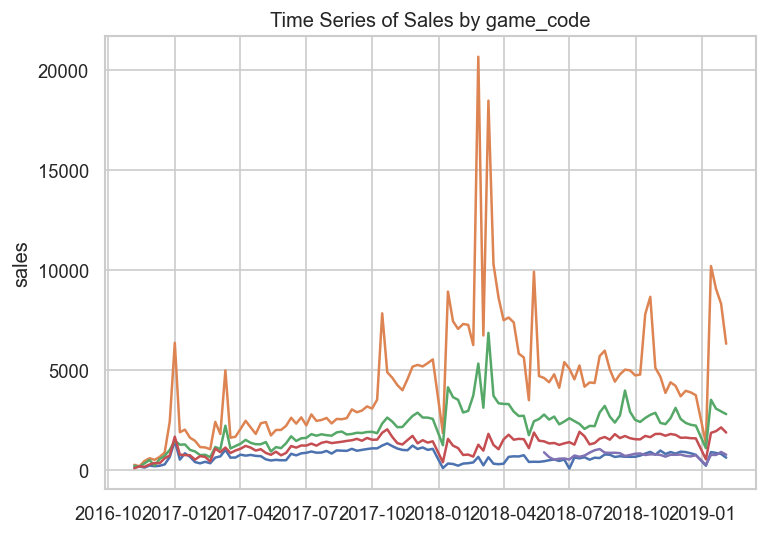

In [33]:
import datetime
game_code_no_outlier = ts_by_game_code.drop([datetime.date(2017,12,31), datetime.date(2018,12,30)])

plt.ylabel('sales')
plt.title('Time Series of Sales by game_code')
plt.plot(game_code_no_outlier)

We can see similarity at time series trends. Let's investidate it by trend and seasonality

## Trend and Seasonality

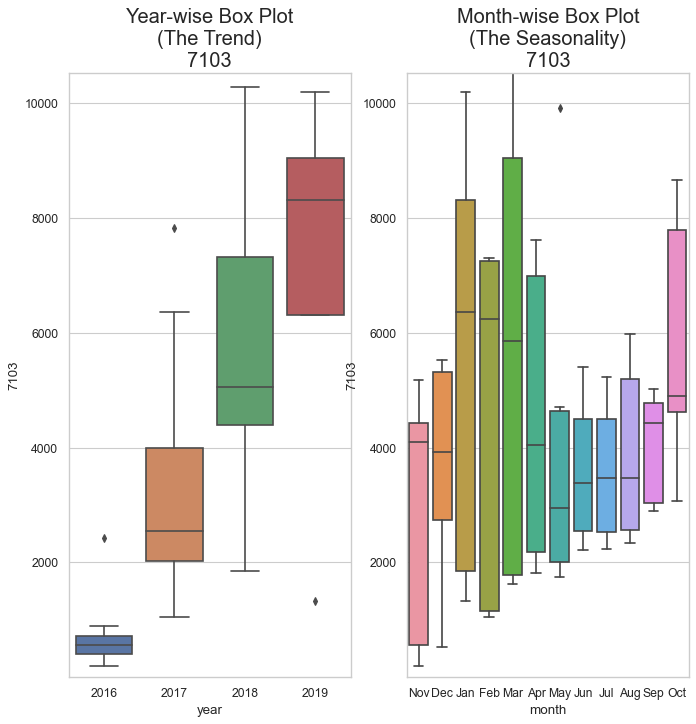

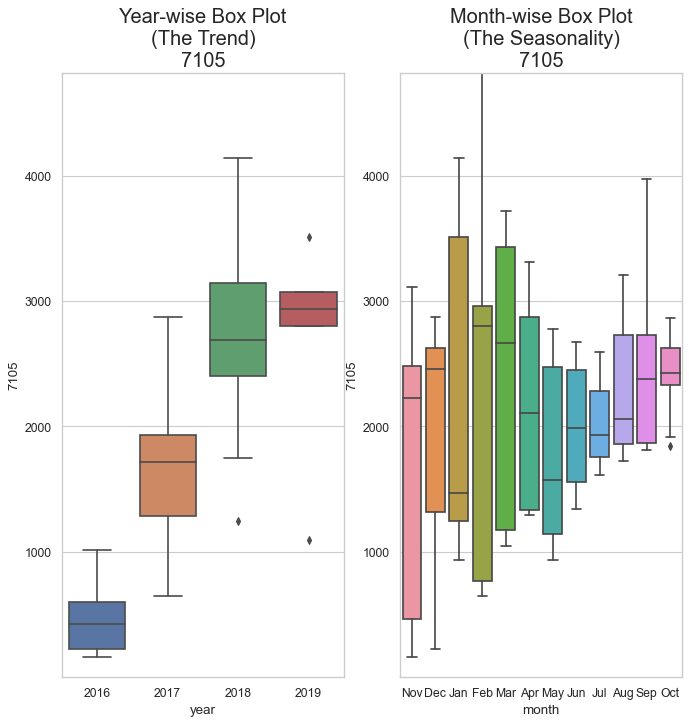

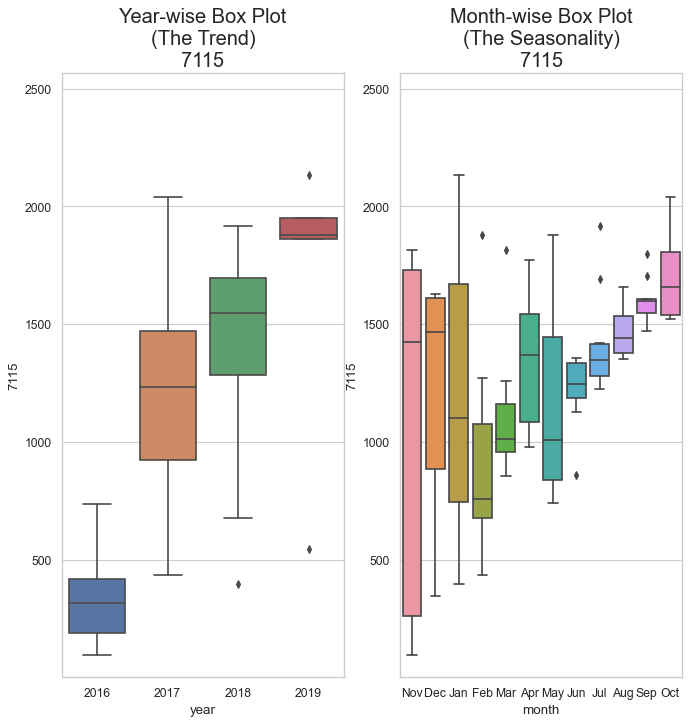

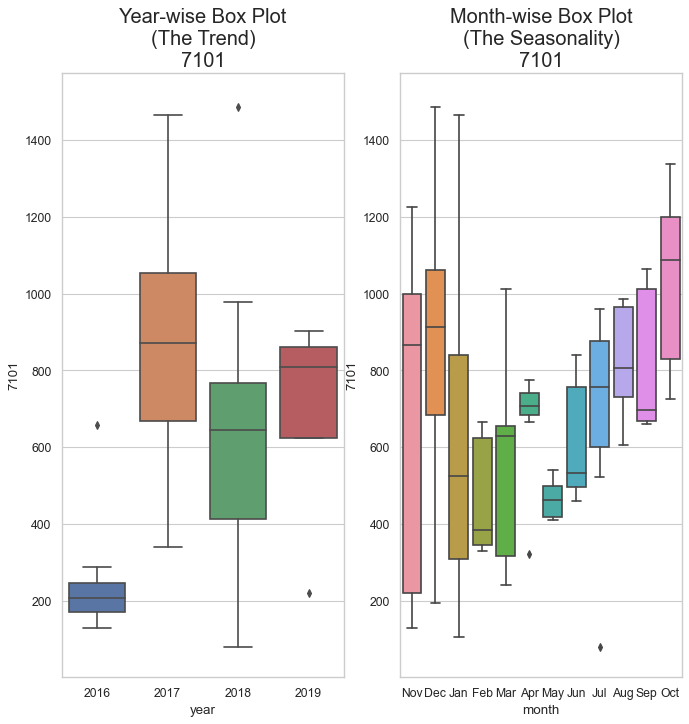

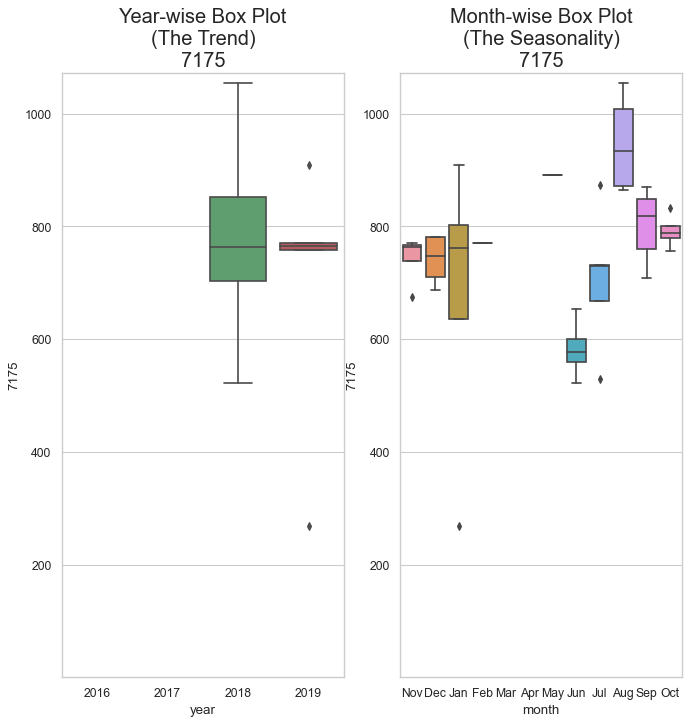

In [34]:
# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution
# Prepare data
#ts_by_game_code.rename(columns = {7101: '7101', 7103: '7103', 7105: '7105', 7115: '7115', 7175: '7175'}, inplace = True)
ts_by_years = ts_by_game_code.reset_index(inplace=False)

ts_by_years['year'] = [d.year for d in ts_by_years.date]
ts_by_years['month'] = [d.strftime('%b') for d in ts_by_years.date]
years = ts_by_years['year'].unique()
# Plot
for i, game_code in enumerate(game_codes):
    fig, axes = plt.subplots(1, 2, figsize=(10,10), dpi= 80)
    year_box = sns.boxplot(x='year', y=game_code, data=ts_by_years, ax=axes[0])
    month_box = sns.boxplot(x='month', y=game_code, data=ts_by_years)
    upper_whisker_limit = ts_by_years[game_code].quantile(0.75) + 1.6 * (ts_by_years[game_code].quantile(0.75) - ts_by_years[game_code].quantile(0.25))
    year_box.set(ylim=(1, upper_whisker_limit))
    month_box.set(ylim=(1,  upper_whisker_limit))
    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)\n' + str(game_code), fontsize=18); 
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)\n' + str(game_code), fontsize=18)
    plt.show()



For the first 3 time series (game types 7103, 7105 and 7115) we see strong uprising trend that testifies to stationarity.
We can see some seasonality - sales are increasing from May to October.
Also we can see several outliers.

<ipython-input-35-2695a84665ac>:6: UserWarning: Trying to create polar plot on an axis that does not have a polar projection.
  plt.polar(mounthly_ts.iloc[:, i])
<ipython-input-35-2695a84665ac>:6: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  plt.polar(mounthly_ts.iloc[:, i])


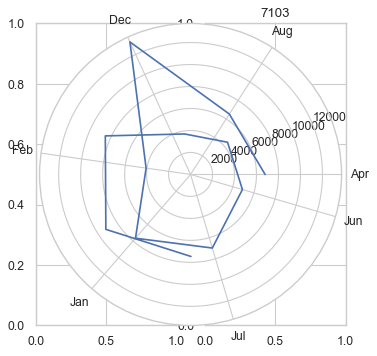

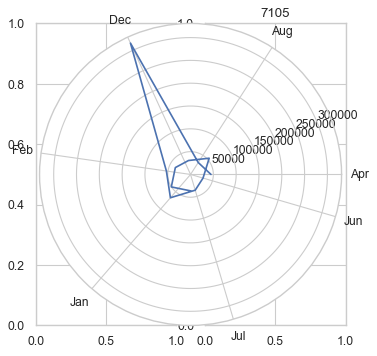

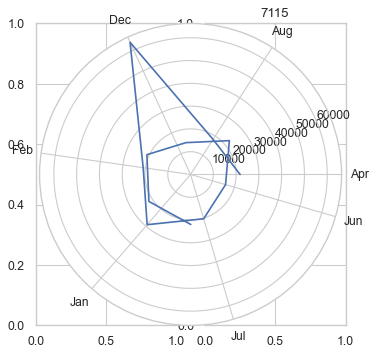

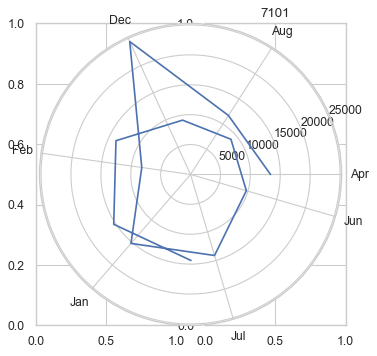

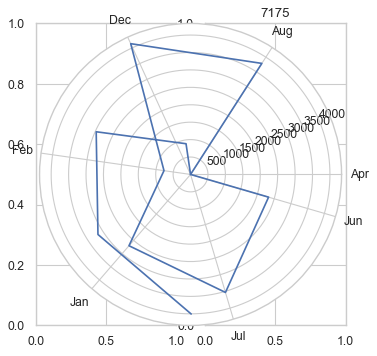

In [35]:
# Polar plots
mounthly_ts = ts_by_years.groupby('month').sum()
for i, game_code in enumerate(game_codes):
    fig, axes = plt.subplots(1, 2, figsize=(5,5), dpi= 80)
    plt.title(str(game_code))
    plt.polar(mounthly_ts.iloc[:, i])
    plt.show()

We can observe a high peak in December and slight tendency to increased sales in cold months

##### Trend, Season Decomposition

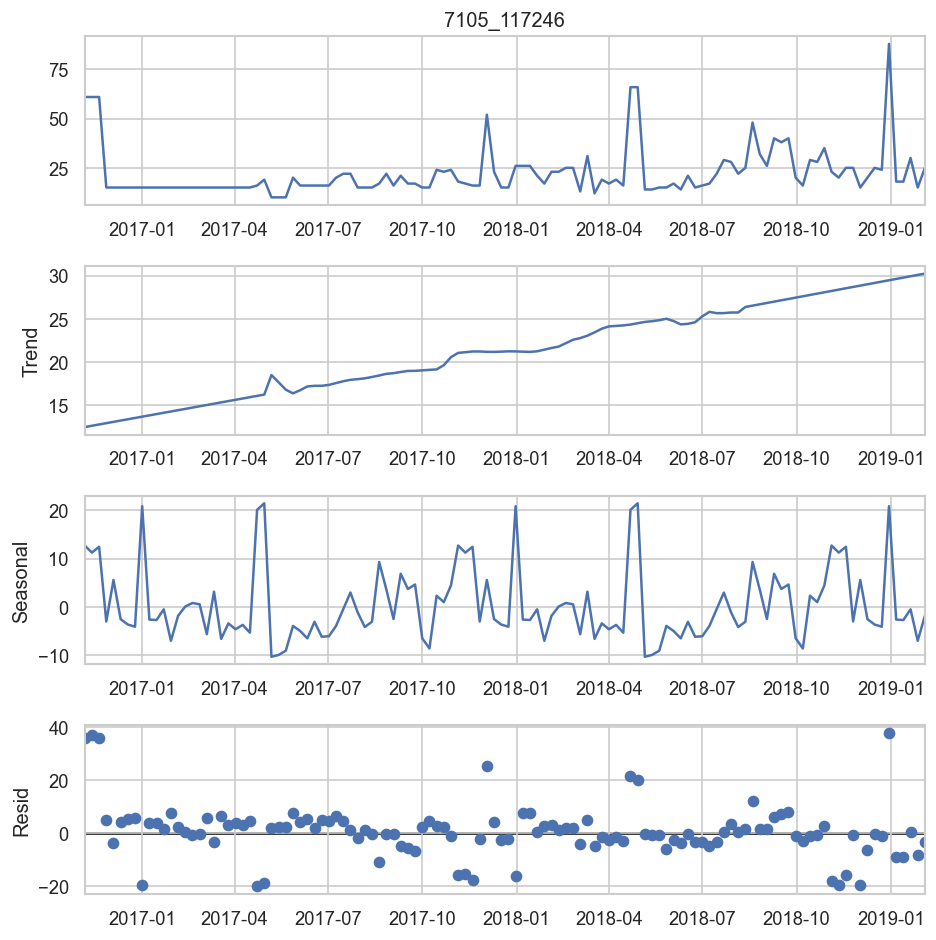

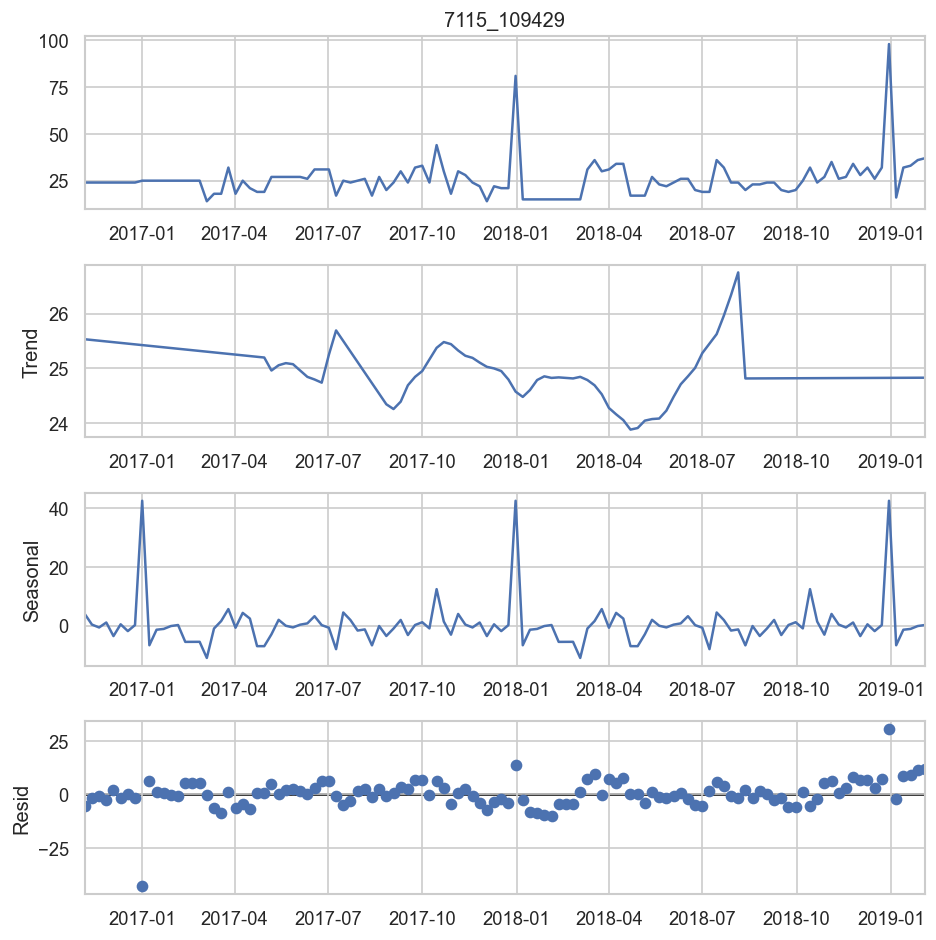

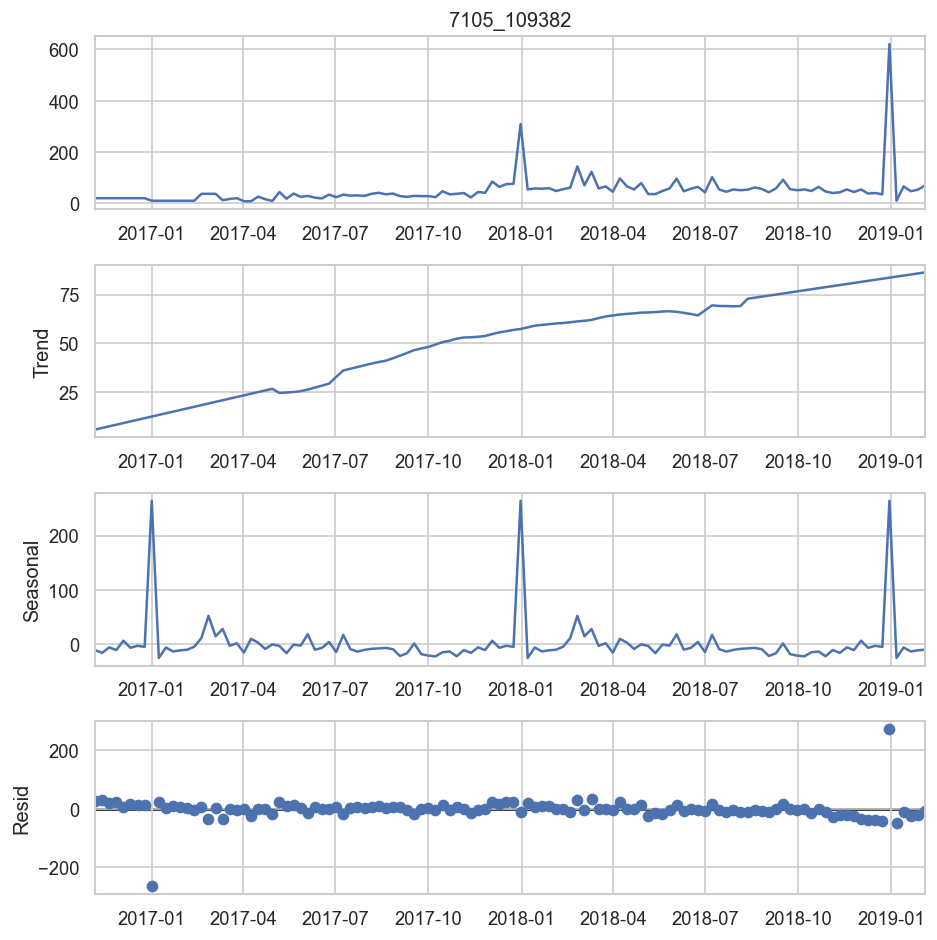

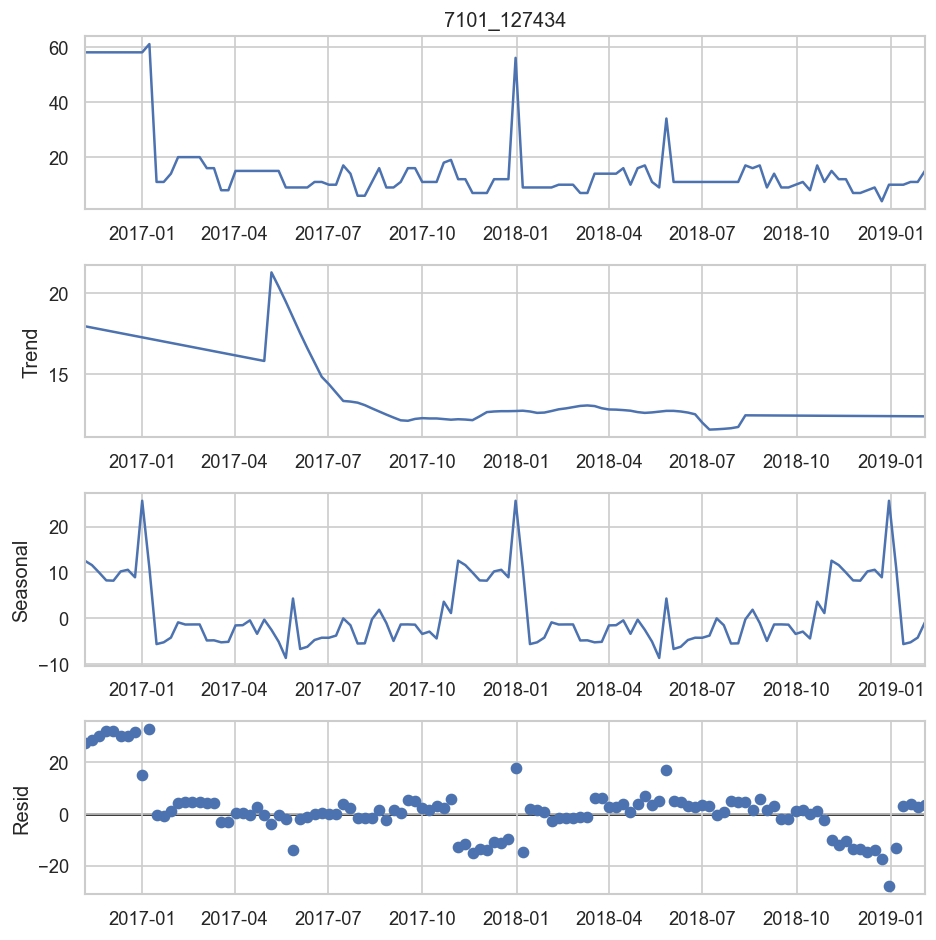

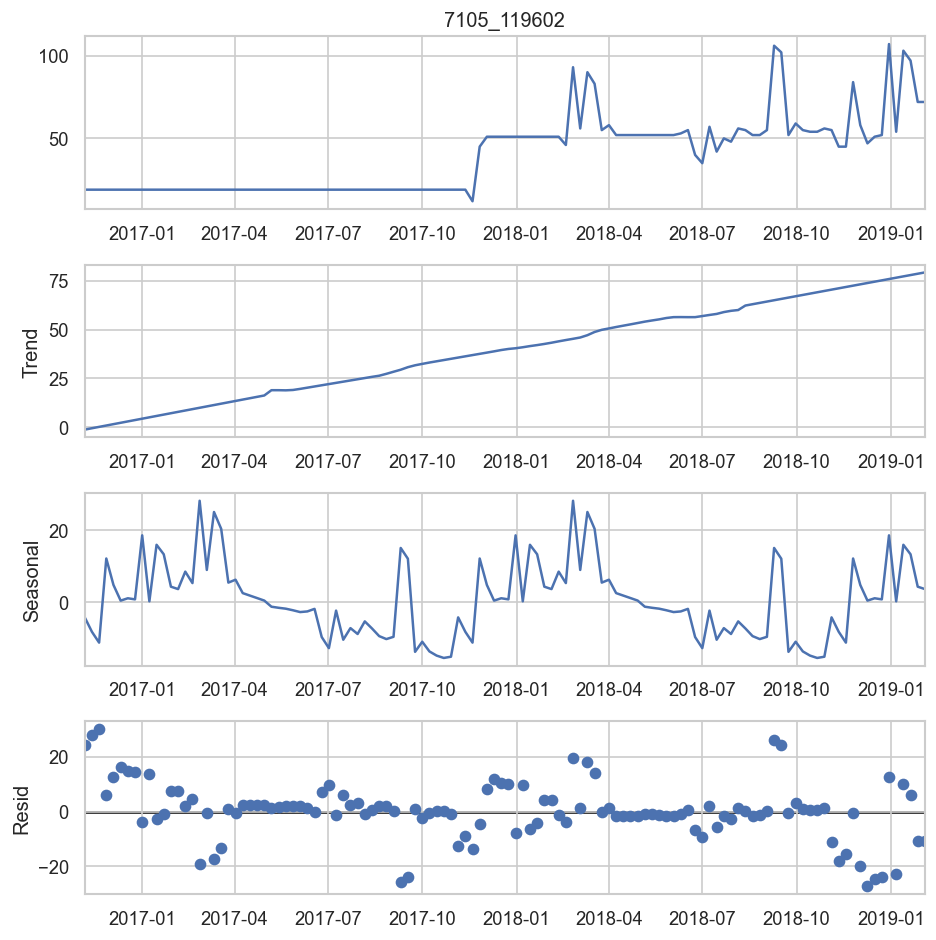

In [36]:
rand5ts =  df_bfill.sample(5, axis=1, random_state=1)
for i, col in enumerate(rand5ts.columns):
    # Multiplicative Decomposition 
    #result_mul = seasonal_decompose(ts_rand_0.iloc[:, i], model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(rand5ts.iloc[:, i], model='additive', extrapolate_trend='freq')

    # Plot
    plt.rcParams.update({'figure.figsize': (8,8)})
    #result_mul.plot().suptitle('Multiplicative Decompose' + str(col), fontsize=22)
    result_add.plot()

## Examinate on outliers

In [37]:
# Let's explore on outliers common_sales

outliers_indices = sesd.seasonal_esd(common_sales, hybrid=True, max_anomalies=5)
for idx in outliers_indices:
    print(f'Anomaly index: {idx}, anomaly value: {common_sales[idx]}')
print('--------\n')

# And compare it with single TS
for i, col in enumerate(rand5ts.columns):
    anomaly_index = sesd.seasonal_esd(rand5ts.iloc[:, i], hybrid=True, max_anomalies=5)
    for idx in anomaly_index:
        print(f'Anomaly index: {idx}, anomaly value: {rand5ts.iloc[idx, i]}')
    print('\n')

Anomaly index: 60, anomaly value: 183407
Anomaly index: 112, anomaly value: 149003
Anomaly index: 70, anomaly value: 27770
Anomaly index: 68, anomaly value: 27909
--------

Anomaly index: 112, anomaly value: 88.0
Anomaly index: 77, anomaly value: 66.0
Anomaly index: 76, anomaly value: 66.0
Anomaly index: 24, anomaly value: 16.0
Anomaly index: 56, anomaly value: 52.0


Anomaly index: 112, anomaly value: 98.0
Anomaly index: 60, anomaly value: 81.0
Anomaly index: 49, anomaly value: 44.0
Anomaly index: 89, anomaly value: 32.0
Anomaly index: 44, anomaly value: 30.0


Anomaly index: 112, anomaly value: 621.0
Anomaly index: 60, anomaly value: 309.0
Anomaly index: 68, anomaly value: 144.0
Anomaly index: 70, anomaly value: 123.0
Anomaly index: 87, anomaly value: 102.0


Anomaly index: 60, anomaly value: 56.0
Anomaly index: 0, anomaly value: 58.0
Anomaly index: 1, anomaly value: 58.0
Anomaly index: 2, anomaly value: 58.0
Anomaly index: 3, anomaly value: 58.0


Anomaly index: 96, anomaly value: 1

We found only 4 outliers in time series of all sales. Found indexes are also occures in particular time series.

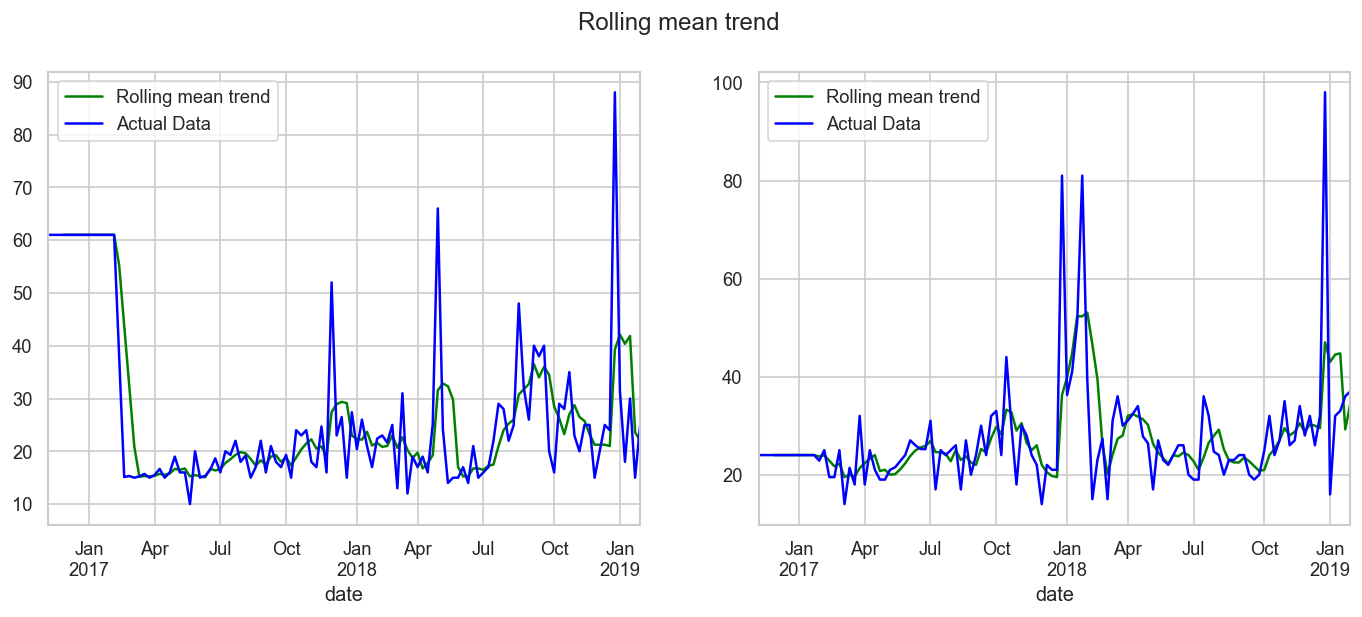

In [38]:
# Smoothing data

rolled_knn = pd.DataFrame() 
for i, col in enumerate(df_knn.columns):
    rolled_knn.insert(i, col, df_knn.iloc[:, i].rolling(window=4).mean(), True)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
rolled_knn[random2ts.columns[0]].plot(subplots=True, title='Rolling mean trend', ax=axes[0], label='Rolling mean trend', color='green')
df_knn[random2ts.columns[0]].plot(subplots=True, title='', ax=axes[0], label='Rolling mean trend', color='blue')
axes[0].legend(["Rolling mean trend", "Actual Data"])
rolled_knn[random2ts.columns[1]].plot(subplots=True, title='Rolling mean trend', ax=axes[1], label='Rolling mean trend', color='green')
df_knn[random2ts.columns[1]].plot(subplots=True, title='Rolling mean trend', ax=axes[1], label='Rolling mean trend', color='blue')
axes[1].legend(["Rolling mean trend", "Actual Data"])

## Stationarity Test

In [39]:
# ADF test
def adf_nonstationarity_counter(df):
    nonstationarity_count = 0
    for i, col in enumerate(df.columns):
        test = sm.tsa.stattools.adfuller(df.iloc[:, i])
        if test[0]> test[4]['5%']: 
            nonstationarity_count +=1
    return('Nonstationary ts number: ' + str(nonstationarity_count) + '\nShare of all TS: '+ str(nonstationarity_count/df.shape[1]))

In [40]:
# initial state
print(adf_nonstationarity_counter(df_knn))

Nonstationary ts number: 68
Share of all TS: 0.19428571428571428


68 of 350 time series (19,4%) are non-stationary

### Using statmodels: Subtracting the Trend Component

In [41]:
detrended = pd.DataFrame() 
for i, col in enumerate(df_knn.columns):
    # Additive Decomposition
    result_add = seasonal_decompose(df_knn.iloc[:, i], model='additive', extrapolate_trend='freq')
    detrended.insert(i, col, (df_knn.iloc[:, i].values - result_add.trend)/ result_add.seasonal, True)
    
print(adf_nonstationarity_counter(detrended))

Nonstationary ts number: 31
Share of all TS: 0.08857142857142856


### Differencing Series

In [42]:
ts1diff = df_zeros.diff(periods=1).dropna()
print(adf_nonstationarity_counter(ts1diff))

Nonstationary ts number: 4
Share of all TS: 0.011428571428571429


Differencing TS shows better results. Only 1.1% of TS appears to be nonstationary

In [43]:
ts1diff_knn = df_knn.diff(periods=1).dropna()
print(adf_nonstationarity_counter(ts1diff_knn))

Nonstationary ts number: 7
Share of all TS: 0.02


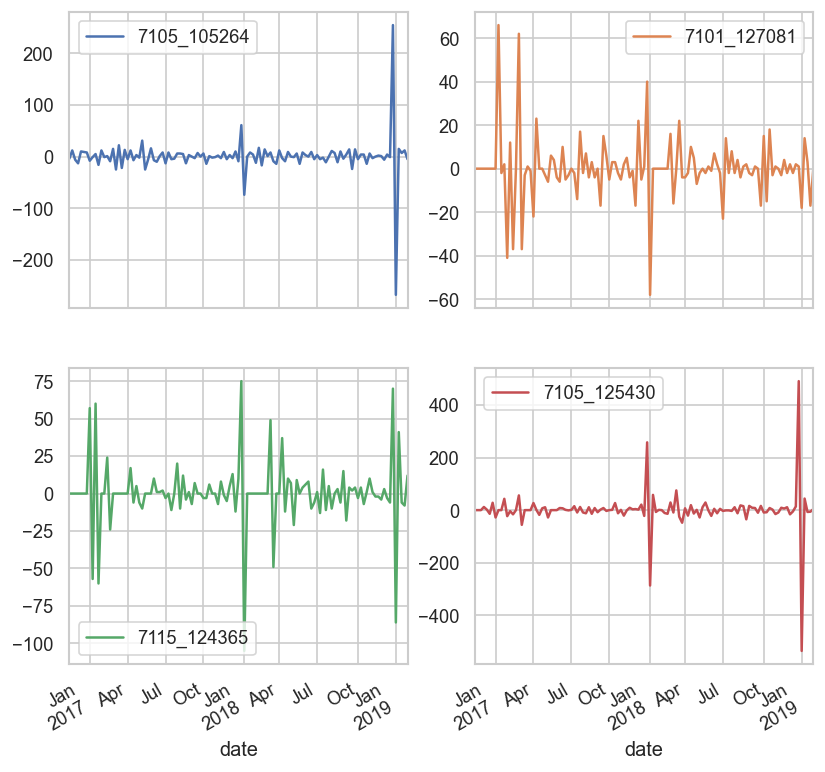

In [44]:
ts_rand_1diff = ts1diff.sample(4, axis=1)
ts_rand_1diff.plot(subplots=True, layout=(2,2), figsize=(8,8))
plt.show()

In [45]:
ts2diff = df_knn.diff(periods=2).dropna()
print(adf_nonstationarity_counter(ts2diff))

Nonstationary ts number: 9
Share of all TS: 0.025714285714285714


Differencing 2 times is worse